In [1]:
from qiskit import QuantumCircuit, transpile, Aer
from math import sqrt, pi, floor
import matplotlib

In [2]:
def read_ES(file_name):
    ES = []
    with open(file_name, "r") as file:
        for line in file.readlines():
            monomials = line.replace(", \n","").split(", ")
            equation = [] 
            for monomial_token in map(lambda x: x.split(" "), monomials):
                if any(monomial_token):
                    monomial = list(map(int, monomial_token))
                else:
                    monomial = []
                equation.append(monomial)
            ES.append(equation)
    return ES

In [3]:
def es_filter(circuit, ES, v_num, inverted = False, barrier = True):
    enumed_ES = list(enumerate(ES))
    if inverted: enumed_ES = enumed_ES[::-1]
    for i, eq in enumed_ES:
        if inverted: eq = eq[::-1]
        for term in eq:
            negated = i + v_num
            if term:
                circuit.mcx(term, i + v_num)
            else:
                circuit.x(i + v_num)
        circuit.x(i + v_num)
        if barrier: circuit.barrier()
        
def es_oracle(circuit, ES, v_num):
    es_filter(circuit, ES, v_num, inverted = False)
    mcx_list = list( range(v_num, v_num + len(ES) - 1) )
    circuit.h(v_num + len(ES) - 1)
    circuit.mcx(mcx_list, v_num + len(ES) - 1)
    circuit.h(v_num + len(ES) - 1)
    circuit.barrier()
    es_filter(circuit, ES, v_num, inverted = True) 

def grover_mirror(circuit, qubits):
    qubits = list(qubits)
    circuit.h(qubits)
    circuit.x(qubits)
    circuit.h(qubits[-1])
    circuit.mcx(qubits[:-1], qubits[-1])
    circuit.h(qubits[-1])
    circuit.x(qubits)
    circuit.h(qubits)
    circuit.barrier()
    
def grover(circuit, ES, v_num, rounds=None, solutions=None):
    if rounds is None:
        if solutions:
            solution_space = pow(2, v_num)
            rounds = floor( pi/4 * sqrt(solution_space / solutions) ) 
        else: rounds = 1
    circuit.h(range(v_num))    
    for i in range(rounds):
        es_oracle(circuit, ES, v_num)
        grover_mirror(circuit, range(v_num))

        
ES = read_ES("polynomials.txt")        
simulator = Aer.get_backend("statevector_simulator")        
circuit = QuantumCircuit(8)
grover(circuit, ES, 4, solutions = 1)
job = simulator.run(circuit)
result = job.result().get_statevector(circuit, decimals=5)
for enum, value in enumerate(result):
    print( f"|{enum%16:04b}> {value.real: 0.3f} {value.imag:+0.3f}i P={abs(value)**2:0.3f}")
    if enum == 15: break

|0000>  0.051 -0.000i P=0.003
|0001>  0.051 -0.000i P=0.003
|0010>  0.051 -0.000i P=0.003
|0011>  0.051 -0.000i P=0.003
|0100>  0.051 -0.000i P=0.003
|0101> -0.980 +0.000i P=0.961
|0110>  0.051 -0.000i P=0.003
|0111>  0.051 -0.000i P=0.003
|1000>  0.051 -0.000i P=0.003
|1001>  0.051 -0.000i P=0.003
|1010>  0.051 -0.000i P=0.003
|1011>  0.051 -0.000i P=0.003
|1100>  0.051 -0.000i P=0.003
|1101>  0.051 -0.000i P=0.003
|1110>  0.051 -0.000i P=0.003
|1111>  0.051 -0.000i P=0.003


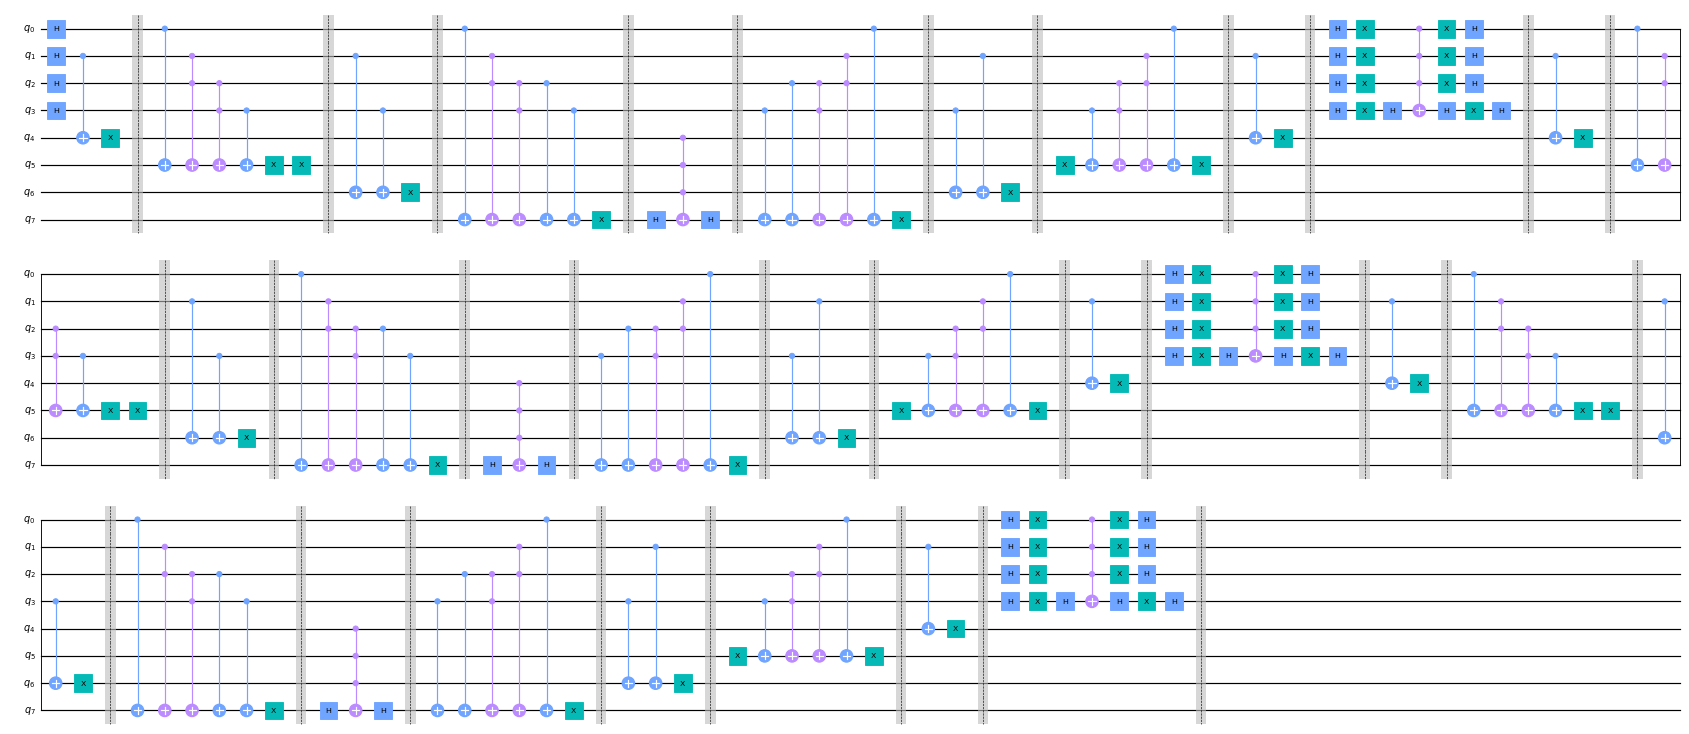

In [4]:
circuit.draw("mpl", 0.6, fold=60)